# Imports

In [1]:
import blocksnet as bn
%matplotlib inline
from shapely.geometry import Point
from geopandas import GeoDataFrame
from blocksnet.models.land_use import LandUse

/home/vasilstar/masterplanning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model

## Читаем модель

In [2]:
city = bn.City.from_pickle('model_0_0_6.pickle')

Выбираем квартал который хотим менять и выбираем новое землепользование для него

In [3]:
selected_block_id = 104
selected_block = city[selected_block_id]
orig_landuse = selected_block.land_use
new_landuse = LandUse.TRANSPORT

# Optimizer

Инициализируем класс для подбора оптимальной застройки сервисов в соответсвии с выбранным землепользование

In [4]:
opt = bn.BlockOptimizer(city_model=city)
result, deleting_update_df = opt.calculate(selected_block=selected_block, new_landuse=new_landuse)

Метод выдает оптимальные типы сервисов и их вместимость

In [ ]:
result['optimal_update_df']

,landfill,pier
104,302000,150


Также можно узнать какие сервисы были снесены перед постройкой новых

In [ ]:
deleting_update_df

,playground,subway_entrance,park,bus_stop,convenience,religion,police,bakery,kindergarten,pharmacy,bank,hairdresser,hotel,cafe,population
104,-130,-30000,-197,-20230,-398,-2537,-5,-369,-280,-31,-109,-10,-1513,-387,-1357


С помощью метода plot мы можем отобразить гистограмму изменений в в квартале по сравнению с оригинальной застройкой

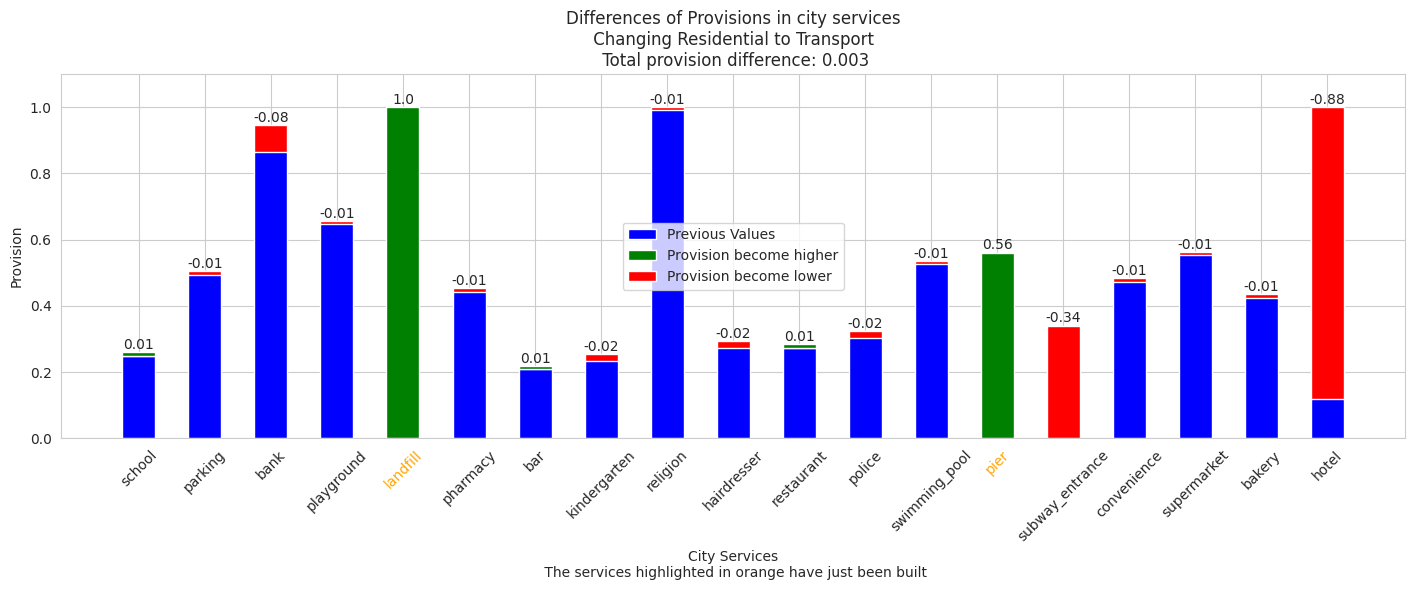

In [ ]:
opt.plot(**result)

Также можно выбрать оптимальное землепользование использовав метод для всех возможных типов землепользования

In [ ]:
best_landuse = selected_block.land_use
temp_diff = 0
for lanuse in LandUse:
    if lanuse == orig_landuse:
        continue
    result = opt.calculate(selected_block=selected_block, new_landuse=lanuse)
    diff = result['total_after'] - result['total_before']
    print(f'{selected_block.land_use} -> {lanuse}: {round(diff, 3)}')
    if diff > temp_diff:
        temp_diff = diff
        best_landuse = lanuse

print(f'best lanuse {best_landuse}')

TypeError: tuple indices must be integers or slices, not str